# Donors Choose - Model 1

In [1]:
# importing required libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# reading datasets
project_data = pd.read_csv("drive/My Drive/ML_data/preprocessed_data.csv")
project_data.head()

,Unnamed: 0,Unnamed: 0.1,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity,std_price,nrm_price,project_summary_numerical
0,0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,students english learners working english seco...,154.60,23,-0.390533,0.015397,0
1,1,140945,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,students arrive school eager learn polite gene...,299.00,1,0.002396,0.029839,0
2,2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,grades_6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,true champions not always ones win guts mia ha...,516.85,22,0.595191,0.051628,0
3,3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,mrs,ky,2016-10-06 21:16:17,grades_prek_2,literacy_language_math_science,literacy_mathematics,techie kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,work unique school filled esl english second l...,232.90,4,-0.177469,0.023228,0
4,4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,mrs,tx,2016-07-11 01:10:09,grades_prek_2,math_science,mathematics,interactive math tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,second grade classroom next year made around 2...,67.98,4,-0.626236,0.006733,0


In [4]:
project_data["project_is_approved"].value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

In [5]:
project_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'teacher_id', 'teacher_prefix',
       'school_state', 'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'essay', 'price', 'quantity', 'std_price', 'nrm_price',
       'project_summary_numerical'],
      dtype='object')

In [6]:
# checking for null values
project_data.isnull().sum()

Unnamed: 0                                           0
Unnamed: 0.1                                         0
id                                                   0
teacher_id                                           0
teacher_prefix                                       0
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                       43
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
essay     

In [0]:
# filling the null values with ''
project_data['project_title'] = project_data['project_title'].fillna('')

In [0]:
# combining essay and project_title columns
project_data['cleaned_text'] = project_data['essay'] + project_data['project_title']

In [0]:
# dropping unecessary columns
project_data = project_data.drop(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'teacher_id', 'project_submitted_datetime', 
                                  'project_resource_summary', 'std_price', 'nrm_price', 'project_essay_1', 'project_essay_2', 
                                  'project_essay_3', 'project_essay_4', 'essay', 'project_title'], axis=1)

In [10]:
# columns left after dropping unecessary columns
project_data.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'project_summary_numerical', 'cleaned_text'],
      dtype='object')

In [0]:
target = project_data['project_is_approved']
features = project_data.drop(['project_is_approved'], axis=1)

In [0]:
# splitting the dataset into train(75%) and test(25%) set
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.25, random_state=123)

In [13]:
print('Shape of Train data', X_train.shape)
print('Shape of Test data', X_test.shape)

Shape of Train data (81936, 10)
Shape of Test data (27312, 10)


**Filtering Text Data (essays & project_title) based on idf values**

In [0]:
tfidf = TfidfVectorizer()
combine_tfidf = tfidf.fit_transform(X_train['cleaned_text'])

# converting to dictionary
combine_dict = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))

In [0]:
tfidf_df = pd.DataFrame(list(combine_dict.items()), columns=['Words', 'IDF Values'])
tfidf_df = tfidf_df.sort_values(by ='IDF Values' )

In [16]:
corpus = tfidf_df
corpus.shape

(61954, 2)

In [17]:
vocab = corpus["Words"].tolist()
vocab[:10]

['students',
 'school',
 'learning',
 'classroom',
 'not',
 'learn',
 'help',
 'many',
 'need',
 'work']

**Tokenizing the Text**

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(vocab)
sequences_train = tokenizer.texts_to_sequences(X_train['cleaned_text'])
sequences_test = tokenizer.texts_to_sequences(X_test['cleaned_text'])

In [19]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 61954 unique tokens.


**Padding the sequences**

The sequences have different lengths and Keras prefers inputs to be vectorized and all inputs to have the same length. 
We will pad all input sequences to have the length of 250

In [20]:
encoded_train = pad_sequences(sequences_train, maxlen=250, padding='post', truncating='post')
print('Shape of data tensor:', encoded_train.shape)

Shape of data tensor: (81936, 250)


In [21]:
encoded_test = pad_sequences(sequences_test, maxlen=250,padding='post', truncating='post')
print('Shape of data tensor:', encoded_test.shape)

Shape of data tensor: (27312, 250)


**Getting the vector representation using Glove vectors**

In [0]:
# Loading Embedding File
pickle_in = open('drive/My Drive/ML_data/glove_vectors','rb')
glove_words = pickle.load(pickle_in)

In [0]:
num_words = len(word2idx) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in word2idx.items():
    if i < len(vocab):
        embedding_vector = glove_words.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector

In [24]:
print(num_words)
print('--------------')
print(embedding_matrix.shape)

61955
--------------
(61955, 300)


**Vectorizing all the categorical features using CountVectorizer**

In [0]:
vect = CountVectorizer(binary=True)

train_prefix = vect.fit_transform(X_train["teacher_prefix"])
test_prefix = vect.transform(X_test["teacher_prefix"])

In [0]:
vect = CountVectorizer(binary=True)

train_state = vect.fit_transform(X_train["school_state"])
test_state = vect.transform(X_test["school_state"])

In [0]:
vect = CountVectorizer(binary=True)

train_grade = vect.fit_transform(X_train["project_grade_category"])
test_grade = vect.transform(X_test["project_grade_category"])

In [0]:
vect = CountVectorizer(binary=True)

train_subcat = vect.fit_transform(X_train["project_subject_categories"])
test_subcat = vect.transform(X_test["project_subject_categories"])

In [0]:
vect = CountVectorizer(binary=True)

train_subcat_1 = vect.fit_transform(X_train["project_subject_subcategories"])
test_subcat_1 = vect.transform(X_test["project_subject_subcategories"])

**Reshaping & Standardizing numerical features**

In [0]:
num_train_1=X_train['project_summary_numerical'].values.reshape(-1, 1)
num_train_2=X_train['price'].values.reshape(-1, 1)
num_train_3=X_train['quantity'].values.reshape(-1, 1)
num_train_4=X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_test_1=X_test['project_summary_numerical'].values.reshape(-1, 1)
num_test_2=X_test['price'].values.reshape(-1, 1)
num_test_3=X_test['quantity'].values.reshape(-1, 1)
num_test_4=X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

In [0]:
# concatenating train numerical features
num_train=np.concatenate((num_train_1,num_train_2,num_train_3,num_train_4),axis=1)

# concatenating test numerical features
num_test=np.concatenate((num_test_1,num_test_2,num_test_3,num_test_4),axis=1)

# Standardizing the features
norm=StandardScaler()
norm_train=norm.fit_transform(num_train)
norm_test=norm.transform(num_test)

In [0]:
# concatencating categorical features
cat_train = hstack([train_prefix,train_state,train_grade,train_subcat,train_subcat_1]).todense()
cat_test = hstack([test_prefix,test_state,test_grade,test_subcat,test_subcat_1]).todense()

In [0]:
# concatenating the numerical & categorical features
all_train = np.hstack((cat_train,norm_train))
all_test = np.hstack((cat_test,norm_test))

In [0]:
final_train = np.expand_dims(all_train,2)
final_test = np.expand_dims(all_test,2)

In [35]:
print(final_train.shape)
print('----------------')
print(final_test.shape)

(81936, 512, 1)
----------------
(27312, 512, 1)


## Defining model architecture

<img src="model.jpeg">

In [36]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings of fixed sized
embedding_layer = Embedding(
  num_words,
  300,
  weights=[embedding_matrix],
  input_length=250,
  trainable=False
)
input_text = Input(shape=(250,),name="input_text")
x = embedding_layer(input_text)
x = LSTM(100,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x)
flatten_1 = Flatten()(x)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [37]:
# Now will prepare all the remaining categorical features
# Teacher Prefix
no_of_unique_prefix  = X_train["teacher_prefix"].nunique()
embedding_size_prefix = int(min(np.ceil((no_of_unique_prefix)/2), 50 ))
print('Unique Categories:', no_of_unique_prefix, 'Embedding Size:', embedding_size_prefix)


# Defining Input and Embedding Layer for the same

input_prefix = Input(shape=(1,), name="teacher_prefix")
embedding_prefix = Embedding(no_of_unique_prefix, embedding_size_prefix, name="emb_pre", trainable=True)(input_prefix)
flatten_2 = Flatten()(embedding_prefix)

lb = LabelEncoder()
encoder_prefix_train = lb.fit_transform(X_train["teacher_prefix"])
encoder_prefix_test = lb.transform(X_test["teacher_prefix"])

Unique Categories: 5 Embedding Size: 3


In [38]:
# School State
no_of_unique_state  = X_train["school_state"].nunique()
embedding_size_state= int(min(np.ceil((no_of_unique_state)/2), 50 ))
print('Unique Categories:', no_of_unique_state, 'Embedding Size:', embedding_size_state)


# Defining Input and Embedding Layer for the same

input_state = Input(shape=(1,), name="school_prefix")
embedding_state = Embedding(no_of_unique_state, embedding_size_state, name="emb_state", trainable=True)(input_state)
flatten_3 = Flatten()(embedding_state)


encoder_state_train = lb.fit_transform(X_train["school_state"])
# encoder_state_cv = lb.transform(X_cv["school_state"])
encoder_state_test = lb.transform(X_test["school_state"])

Unique Categories: 51 Embedding Size: 26


In [39]:
# For project_grade_category
no_of_unique_grade  = X_train["project_grade_category"].nunique()
embedding_size_grade = int(min(np.ceil((no_of_unique_grade)/2), 50 ))
print('Unique Categories:', no_of_unique_grade, 'Embedding Size:', embedding_size_grade)


# Defining Input and Embedding Layer for the same

input_grade= Input(shape=(1,),name="grade_cat")
embedding_grade = Embedding(no_of_unique_grade, embedding_size_grade, name="emb_grade", trainable=True)(input_grade)
flatten_4 = Flatten()(embedding_grade)


encoder_grade_train = lb.fit_transform(X_train["project_grade_category"])
# encoder_grade_cv = lb.transform(X_cv["project_grade_category"])
encoder_grade_test = lb.transform(X_test["project_grade_category"])

Unique Categories: 4 Embedding Size: 2


In [40]:
# For project_subject_categories
no_of_unique_subcat  = X_train["project_subject_categories"].nunique()
embedding_size_subcat = int(min(np.ceil((no_of_unique_subcat)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat,'Embedding Size:', embedding_size_subcat)


# Defining Input and Embedding Layer for the same

input_subcat= Input(shape=(1,),name="sub_cat")
embedding_subcat = Embedding(no_of_unique_subcat,embedding_size_subcat,name="emb_subcat",trainable=True)(input_subcat)
flatten_5 = Flatten()(embedding_subcat)

le = LabelEncoder()
le.fit(X_train["project_subject_categories"])
X_test["project_subject_categories"] = X_test["project_subject_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)

le.classes_ = np.append(le.classes_, '<unknown>')
encoder_subcat_train = le.transform(X_train["project_subject_categories"])
encoder_subcat_test= le.transform(X_test["project_subject_categories"])

Unique Categories: 51 Embedding Size: 26


In [41]:
# For project_subject_subcategories
no_of_unique_subcat_1  = X_train["project_subject_subcategories"].nunique()
embedding_size_subcat_1 = int(min(np.ceil((no_of_unique_subcat_1)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat_1,'Embedding Size:', embedding_size_subcat_1)

# Defining Input and Embedding Layer for the same

input_subcat_1= Input(shape=(1,),name="sub_cat_1")
embedding_subcat_1 = Embedding(no_of_unique_subcat_1,embedding_size_subcat_1,name="emb_subcat_1",trainable=True)(input_subcat_1)
flatten_6 = Flatten()(embedding_subcat_1)


le = LabelEncoder()
le.fit(X_train["project_subject_subcategories"])
X_test["project_subject_subcategories"] = X_test["project_subject_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)

le.classes_ = np.append(le.classes_, '<unknown>')
encoder_subcat_1_train = le.transform(X_train["project_subject_subcategories"])
encoder_subcat_1_test= le.transform(X_test["project_subject_subcategories"])

Unique Categories: 397 Embedding Size: 50


In [0]:
# Defining the Input and Embedding Layer for the same

num_feats = Input(shape=(4,),name="numerical_features")
num_feats_ = Dense(100,activation="relu",kernel_initializer="he_normal")(num_feats)

In [44]:
print("Building Model-1")
x_concatenate = concatenate([flatten_1, flatten_2, flatten_3, flatten_4, flatten_5, flatten_6, num_feats_])

x = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concatenate)

x=Dropout(0.5)(x)

x = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)

x=Dropout(0.5)(x)

x = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)

output = Dense(2, activation='softmax', name='output')(x)
model_1 = Model(inputs=[input_text, input_prefix, input_state, input_grade,
                        input_subcat, input_subcat_1, num_feats],outputs=[output])

Building Model-1


In [0]:
train_data_1 = [encoded_train,encoder_prefix_train,encoder_state_train,
              encoder_grade_train,encoder_subcat_train,encoder_subcat_1_train,norm_train]
test_data_1 = [encoded_test,encoder_prefix_test,encoder_state_test,encoder_grade_test,
             encoder_subcat_test,encoder_subcat_1_test,norm_test]

Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

In [0]:
checkpoint_1 = ModelCheckpoint("model_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop_1 = EarlyStopping(monitor = 'val_loss', 
                            mode="min",
                            min_delta = 0, 
                            patience = 5,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr_1 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, verbose = 1, min_delta = 0.0001)

tensorboard_1 = TensorBoard(log_dir='graph_1', histogram_freq=0, batch_size=512, write_graph=True, write_grads=False, write_images=False, 
                            embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_1 = [checkpoint_1, earlystop_1, tensorboard_1, reduce_lr_1]

In [0]:
# Defining Custom ROC-AUC function
from sklearn.metrics import roc_auc_score

def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return tf.py_func(auc1, (y_true, y_pred), tf.double)

In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [49]:
model_1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[auroc])


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [50]:
history_1 = model_1.fit(train_data_1, Y_train, batch_size=512,
                        epochs=30, validation_data=(test_data_1,Y_test), callbacks=callbacks_1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 81936 samples, validate on 27312 samples


Epoch 1/30
81936/81936 [==============================] - 106s 1ms/step - loss: 1.0864 - auroc: 0.6632 - val_loss: 0.7569 - val_auroc: 0.7249

Epoch 00001: val_loss improved from inf to 0.75690, saving model to model_1.h5
Epoch 2/30
81936/81936 [==============================] - 103s 1ms/step - loss: 0.6238 - auroc: 0.7287 - val_loss: 0.5408 - val_auroc: 0.7376

Epoch 00002: val_loss improved from 0.75690 to 0.54081, saving model to model_1.h5
Epoch 3/30
81936/81936 [==============================] - 103s 1ms/step - loss: 0.5003 - auroc: 0.7453 - val_loss: 0.4659 - val_auroc: 0.7488

Epoch 00003: val_loss improved from 0.54081 to 0.46587, saving model to model_1.h5
Epoch 4/30
81936/81936 [==============================] - 102s 1ms/step - loss: 0.4485 - auroc: 0.7552 - val_loss: 0.4689 - val_auroc: 0.7574

Epoch 00004: val_loss did not improve

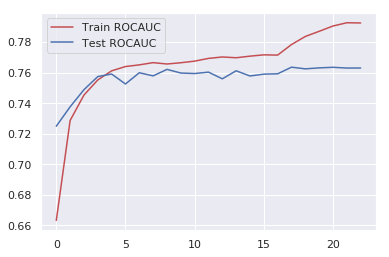

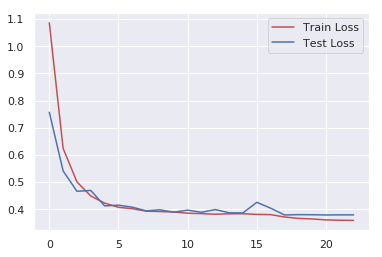

In [52]:
sns.set()
plt.plot(history_1.history['auroc'], 'r')
plt.plot(history_1.history['val_auroc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()


plt.plot(history_1.history['loss'], 'r')
plt.plot(history_1.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

### AUC Score for Model 1 - 0.7630